- importing libiaries 
- set API key
- define variables 

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from datetime import date, timedelta, datetime
import seaborn as sns
#import cryptocompare as cc
import requests
#import IPython
import yaml
import json

yaml_file = open('api_key/api_config_cc.yml', 'r')
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
api_key = p['api_key']


data_limit = 2000

btc = 'BTC'
eth = 'ETH'



define two functions 
- api request 
- data preparation 

In [4]:
def api_request(url):
    headers = {'authorization': 'Apikey ' + api_key,}
    session = requests.Session()
    session.headers.update(headers)

    response = session.get(url)

    #print('Response Status Code:', response.status_code)

    blockchain_data_dict = json.loads(response.text)

    #print('Response Content:', response.text)
    #print('blockchain_data_dict:', blockchain_data_dict)


    df = pd.DataFrame.from_dict(blockchain_data_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)

    return(df)
def prepare_pricedata(df):
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.drop(columns=['time', 'conversionType', 'conversionSymbol'], inplace=True)
    return df

base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
df_btc = api_request(f'{base_url}{btc}&tsym=USD&limit={data_limit}')
btc_price_df = prepare_pricedata(df_btc)
print(btc_price_df.head(3))
df_eth = api_request(f'{base_url}{eth}&tsym=USD&limit={data_limit}')
eth_price_df = prepare_pricedata(df_eth)
print(eth_price_df.head(3))





       high      low     open  volumefrom      volumeto    close       date
0   9969.58  9638.20  9732.63    87754.89  8.653286e+08  9906.04 2017-11-28
1  11417.84  8938.70  9906.04   233325.32  2.418792e+09  9837.86 2017-11-29
2  10689.06  9023.77  9848.05   187008.87  1.836210e+09  9946.76 2017-11-30
     high     low    open  volumefrom      volumeto   close       date
0  478.46  459.91  475.20   549199.04  2.580053e+08  466.27 2017-11-28
1  515.44  409.35  466.24  1321734.67  6.195788e+08  427.42 2017-11-29
2  460.81  396.14  427.30  1023187.30  4.380136e+08  434.85 2017-11-30


on-chain API request

In [45]:
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
onchain_btc_df = api_request(f'{base_url}{btc}&limit={data_limit}')
onchain_eth_df = api_request(f'{base_url}{eth}&limit={data_limit}')
onchain_btc_df.head(3)



,id,symbol,time,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
0,1182,BTC,1511827200,313593273,336776947,581913,1030379,365977,275870749,33859,7.871893,496591,1.049821e+07,1.347001e+12,551.077419,1062805,1.670739e+07
1,1182,BTC,1511913600,314083774,337419505,642558,1136365,398090,276268839,37662,8.194235,496764,1.161143e+07,1.347001e+12,498.244186,1064409,1.670955e+07
2,1182,BTC,1512000000,314551084,338012487,592982,1089772,384386,276653225,32494,7.018446,496931,1.133120e+07,1.347001e+12,510.566265,1068302,1.671164e+07


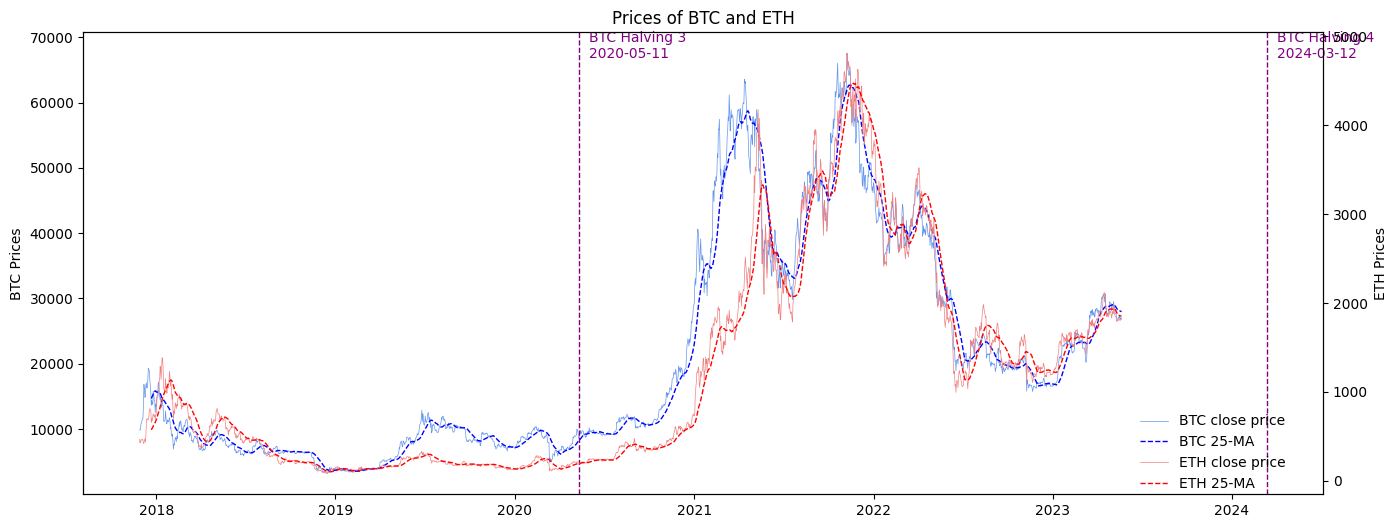

In [25]:
rolling_window = 25
btc_price_df['close_avg'] = btc_price_df['close'].rolling(window=rolling_window).mean()
eth_price_df['close_avg'] = eth_price_df['close'].rolling(window=rolling_window).mean()

def func_halving_dates(ax, df_x_dates, df_ax1_y):
    halving_dates = ['2009-01-03', '2012-11-28', '2016-07-09', '2020-05-11', '2024-03-12', '2028-06-01'] 
    dates_list = [datetime.strptime(date, '%Y-%m-%d').date() for date in halving_dates]
    

    for i, datex in enumerate(dates_list):
        halving_ts = pd.Timestamp(datex)
        x_max = df_x_dates.max() + timedelta(days=365)
        x_min = df_x_dates.min() - timedelta(days=365)
        if (halving_ts < x_max) and (halving_ts > x_min):
            ax.axvline(x=datex, color = 'purple', linewidth=1, linestyle='dashed')
            ax.text(x=datex  + timedelta(days=20), y=df_ax1_y.max()*0.99, s='BTC Halving ' + str(i) + '\n' + str(datex), color = 'purple')

def func_twinx_legend(ax1, ax2, x_anchor=1.18, y_anchor=1.0):
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=1, facecolor='white', framealpha=0, bbox_to_anchor=(x_anchor, y_anchor))
    ax2.get_legend().remove()



fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=btc_price_df, x='date', y='close', color='cornflowerblue', linewidth=0.5, label=f'{btc} close price', ax=ax1)
sns.lineplot(data=btc_price_df, x='date', y='close_avg', color='blue', linestyle='dashed', linewidth=1.0, 
    label=f'{btc} {rolling_window}-MA', ax=ax1)
ax1.set_ylabel(f'{btc} Prices')
ax1.set(xlabel=None)
ax2 = ax1.twinx()
sns.lineplot(data=eth_price_df, x='date', y='close', color='lightcoral', linewidth=0.5, label=f'{eth} close price', ax=ax2)
sns.lineplot(data=eth_price_df, x='date', y='close_avg', color='red', linestyle='dashed', linewidth=1.0, label=f'{eth} {rolling_window}-MA', ax=ax2)
ax2.set_ylabel(f'{eth} Prices')
func_twinx_legend(ax1, ax2, 0.98, 0.2)
func_halving_dates(ax1, btc_price_df.date, btc_price_df.close)
#ax1.set_yscale('log'), ax2.set_yscale('log')
plt.title(f'Prices of {btc} and {eth}')
plt.show()

In [26]:
def onchain_data(df):
    df['date'] = pd.to_datetime(df['time'], unit='s')
    df.drop(columns='time', inplace=True)
    df = df[df['hashrate'] > 0.0]
    return df

onchain_info_btc_df = onchain_data(onchain_btc_df)
onchain_info_eth_df = onchain_data(onchain_eth_df)

onchain_info_btc_df.head(3)


,id,symbol,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply,date
0,1182,BTC,313593273,336776947,581913,1030379,365977,275870749,33859,7.871893,496591,1.049821e+07,1.347001e+12,551.077419,1062805,1.670739e+07,2017-11-28
1,1182,BTC,314083774,337419505,642558,1136365,398090,276268839,37662,8.194235,496764,1.161143e+07,1.347001e+12,498.244186,1064409,1.670955e+07,2017-11-29
2,1182,BTC,314551084,338012487,592982,1089772,384386,276653225,32494,7.018446,496931,1.133120e+07,1.347001e+12,510.566265,1068302,1.671164e+07,2017-11-30


In [36]:

def prepare_balancedistribution(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)


  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
df_raw = api_request(f'{base_url}{btc}&limit={data_limit}')
df_distr = prepare_balancedistribution(df_raw)
df_distr.head(3)

,date,totalVolume,addressesCount,range
0,2017-11-28,2341.039439,13185949.0,0.0_to_0.001
1,2017-11-28,17250.124554,4296224.0,0.001_to_0.01
2,2017-11-28,109635.659650,3492078.0,0.01_to_0.1


## Correlation between Btc and Eth 

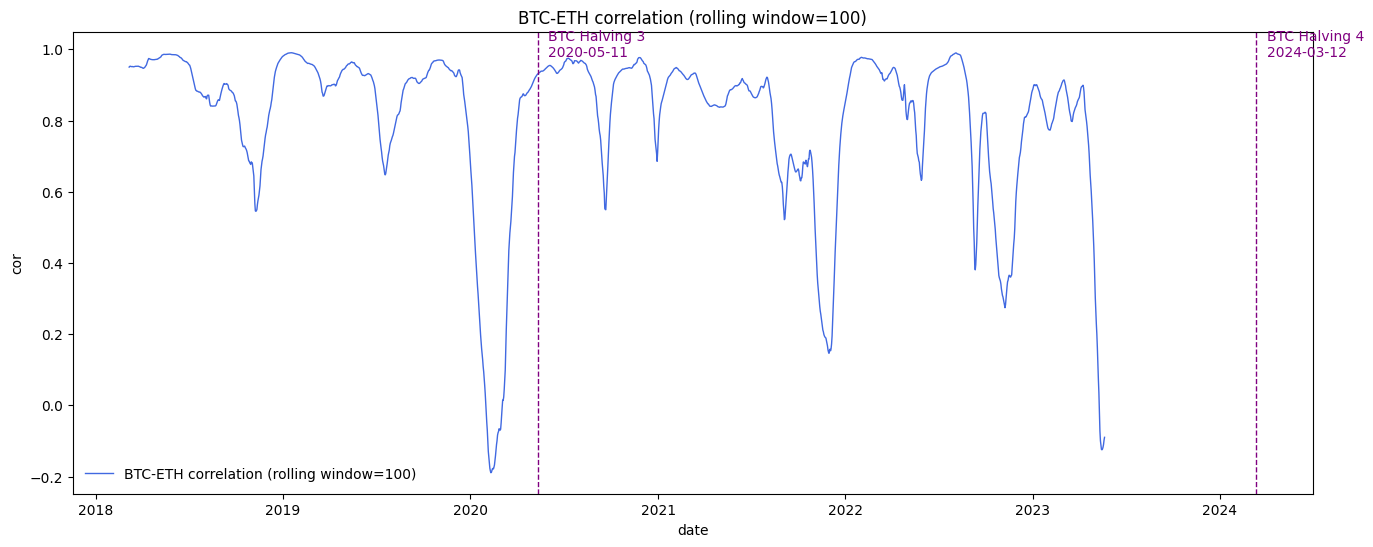

In [46]:
rolling_window = 100
df_price_merged = pd.DataFrame.from_dict(data={f'close_{eth}': eth_price_df['close'], f'close_{btc}': btc_price_df['close'], 'date': btc_price_df['date']})

df_temp = pd.DataFrame({'cor': eth_price_df.close.rolling(rolling_window).corr(btc_price_df.close).dropna()})

df_cor_dateindex = df_price_merged.join(df_temp[::-1].set_index(df_temp.index)).dropna().set_index('date')

fig, ax1 = plt.subplots(figsize=(16, 6))
label = f'{btc}-{eth} correlation (rolling window={rolling_window})'
sns.lineplot(data=df_cor_dateindex, x=df_cor_dateindex.index, y='cor', color='royalblue', linewidth=1.0, label=label)
func_halving_dates(ax1, df_cor_dateindex.index, df_cor_dateindex[f'cor'])
plt.legend(framealpha=0);
plt.title(label);


## Distribution of Total Address Count for each coin by Holder Amount

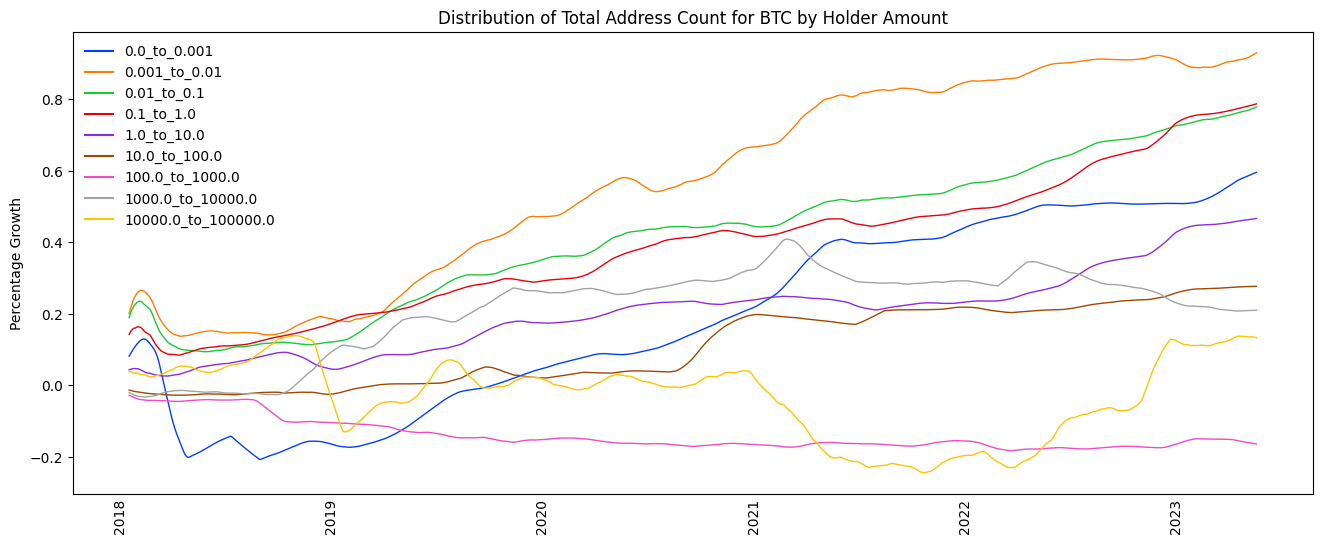

In [52]:
distribution_df = df_distr.copy()

for i in list(distribution_df.range.unique()):
    distribution_df.loc[df_distr.range == i, 'addressesCount_pct_cum'] = distribution_df[distribution_df.range == i]['addressesCount'].pct_change().dropna().cumsum().rolling(window=50).mean()
distribution_df.dropna(inplace=True)

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=distribution_df, x='date', hue='range', linewidth = 1.0, y='addressesCount_pct_cum', ax=ax1, palette='bright')
plt.ylabel('Percentage Growth')
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
plt.title(f'Distribution of Total Address Count for {btc} by Holder Amount')
plt.legend(framealpha=0)
plt.show()



## Network Hashrate and Difficulty

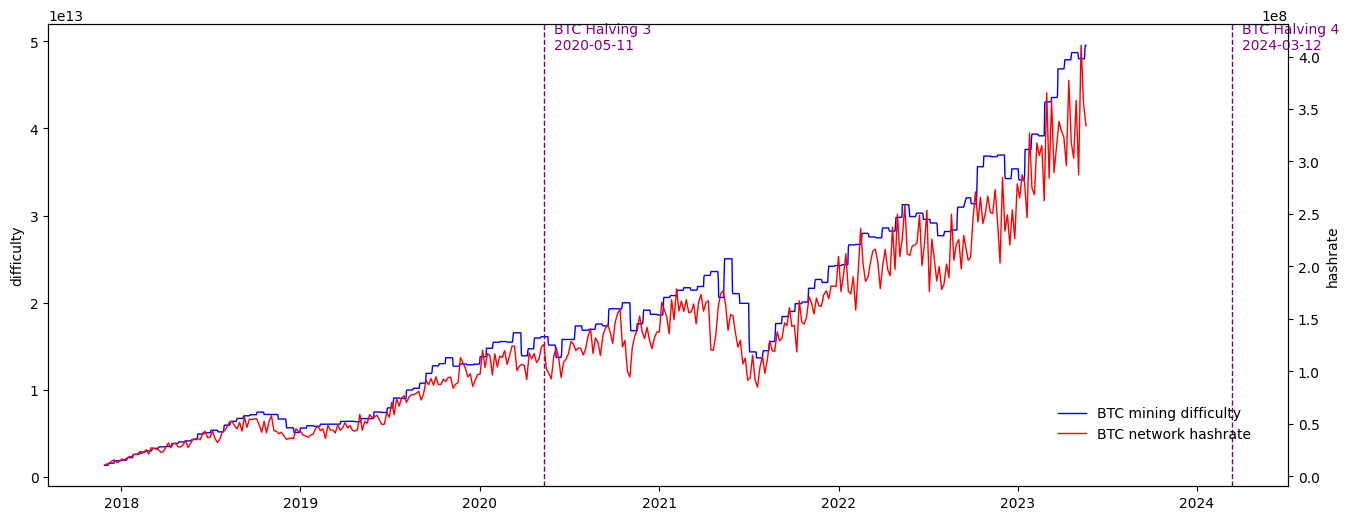

In [56]:
fig, ax1 = plt.subplots(figsize=(16, 6))

sns.lineplot(data=onchain_info_btc_df, x='date', y='difficulty', linewidth=1.0, color='blue', ax=ax1, label=f'{btc} mining difficulty')


ax2=ax1.twinx()

sns.lineplot(data=onchain_info_btc_df[::5], x='date', y='hashrate', linewidth=1.0, color='red', ax=ax2, label =f'{btc} network hashrate')
func_twinx_legend(ax1, ax2, 0.98, 0.2)
func_halving_dates(ax1, onchain_info_btc_df.date, onchain_info_btc_df.difficulty)

ax1.set(xlabel=None)
plt.title=(f'{btc} Mining Difficulty and Hashrate');
plt.show();




## Coinprice and Difficulty